<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/3_validate_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import time
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from skimage.segmentation import mark_boundaries

## Specify path, random seed, and band names

In [4]:
# path = 'agrifield_data/'
path = 'gdrive/MyDrive/agrifield_data/'

In [5]:
# drive.flush_and_unmount()

In [6]:
if 'gdrive' in path:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

## Extract labels

In [8]:
data_dir = path + 'data'
train_label_collection = 'ref_agrifieldnet_competition_v1_labels_train'

In [9]:
f = os.listdir(os.path.join(data_dir, train_label_collection))[0]
with open(os.path.join(data_dir, train_label_collection, f, 'stac.json')) as ll:
    label_json = json.load(ll)

In [10]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## List models

In [11]:
model_dir = os.path.join(path, 'models')
models = os.listdir(model_dir)
models.sort()
models

['1666567767_Sun Oct 23 23:29:27 2022_transformer',
 '1666567834_Sun Oct 23 23:30:34 2022_transformer',
 '1666568678_Sun Oct 23 23:44:38 2022_transformer',
 '1666568845_Sun Oct 23 23:47:25 2022_transformer']

In [12]:
model_name = models[-1]
os.listdir(os.path.join(model_dir, model_name))

['last_model.pth',
 'best_model.pth',
 'predictions_val.csv',
 'predictions_test.csv']

## Load predictions

In [13]:
df = pd.read_csv(os.path.join(model_dir, model_name, 'predictions_val.csv'))
df

,field_id,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice,crop_type,field_area,data_path
0,2,17.863952,21.389661,12.439615,4.769005,19.961188,18.497163,55.696275,9.929184,28.955636,22.956523,32.782628,13.244335,9.514830,2,268.0,data_cropped/6117.0_d838c.tif
1,4,2.079540,2.281340,3.443346,2.417882,4.287369,4.266822,2.191983,0.883677,2.732362,1.869808,2.270507,2.370055,0.905310,2,32.0,data_cropped/1234.0_516a0.tif
2,5,1.310770,3.020650,1.419340,2.610075,3.656757,0.950977,1.172173,14.110898,5.636921,2.174362,3.920650,1.748647,3.267781,2,45.0,data_cropped/6408.0_0c691.tif
3,15,1.826647,2.264031,1.748891,3.050449,4.139049,1.355242,0.907677,1.452012,2.626111,1.148424,2.549379,6.548051,1.384035,2,31.0,data_cropped/2712.0_048eb.tif
4,24,1.353994,3.142085,1.273449,0.591823,3.604212,1.134877,3.464278,1.673673,3.757929,1.919581,3.834338,2.286236,0.963525,2,29.0,data_cropped/5494.0_e5b6a.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,7305,5.406169,3.965868,3.490047,1.498671,4.470413,4.311110,12.306997,2.501896,7.744050,4.424707,6.303095,2.389631,3.187343,13,62.0,data_cropped/5477.0_6fb0c.tif
1073,7309,3.701206,2.355642,3.077132,1.499974,3.328174,2.496104,4.849047,1.802670,4.687505,2.398232,3.276198,2.041421,2.486694,13,38.0,data_cropped/5771.0_e9fa0.tif
1074,7311,1.344250,1.158925,1.010313,0.346005,1.327069,0.872310,2.821677,0.847716,2.389694,1.264974,1.795196,0.798999,1.022872,13,17.0,data_cropped/6260.0_0d0b9.tif
1075,7320,1.331588,0.479652,0.697941,4.162221,0.611792,1.226154,0.318039,0.911980,1.194112,0.472278,0.687102,0.395827,2.511314,36,15.0,data_cropped/4732.0_e2cf7.tif


In [14]:
crop_labels = np.unique(df['crop_type'])
crop_columns = [crop_dict[key] for key in crop_labels]
probs = df[crop_columns].values
field_ids = df['field_id']
gt = df['crop_type']

In [15]:
probs.shape, field_ids.shape, gt.shape

((1077, 10), (1077,), (1077,))

In [16]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

           1       0.94      0.04      0.08       418
           2       0.00      0.00      0.00       202
           3       0.05      0.30      0.08        20
           4       0.88      0.50      0.63       315
           6       0.09      0.43      0.15        35
           8       0.05      0.70      0.10        10
           9       0.41      0.87      0.56        61
          13       0.04      0.25      0.07        12
          16       0.00      0.50      0.01         2
          36       0.00      0.00      0.00         2

    accuracy                           0.24      1077
   macro avg       0.25      0.36      0.17      1077
weighted avg       0.65      0.24      0.26      1077



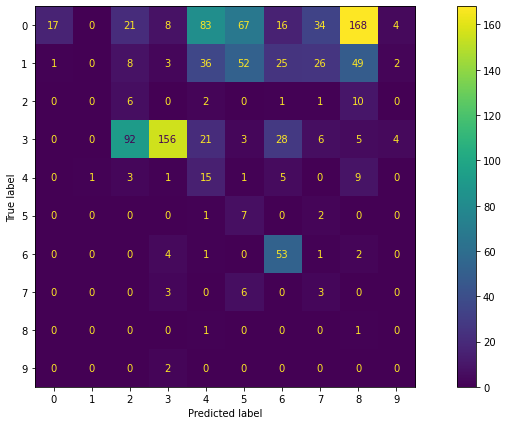

In [17]:
# Confusion matrix
cm = confusion_matrix(gt, np.array(crop_labels)[np.argmax(probs, axis=1)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [21]:
df['predicted'] = np.array(crop_labels)[np.argmax(probs, axis=1)]

In [22]:
df

,field_id,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice,crop_type,field_area,data_path,predicted
0,2,17.863952,21.389661,12.439615,4.769005,19.961188,18.497163,55.696275,9.929184,28.955636,22.956523,32.782628,13.244335,9.514830,2,268.0,data_cropped/6117.0_d838c.tif,8
1,4,2.079540,2.281340,3.443346,2.417882,4.287369,4.266822,2.191983,0.883677,2.732362,1.869808,2.270507,2.370055,0.905310,2,32.0,data_cropped/1234.0_516a0.tif,6
2,5,1.310770,3.020650,1.419340,2.610075,3.656757,0.950977,1.172173,14.110898,5.636921,2.174362,3.920650,1.748647,3.267781,2,45.0,data_cropped/6408.0_0c691.tif,9
3,15,1.826647,2.264031,1.748891,3.050449,4.139049,1.355242,0.907677,1.452012,2.626111,1.148424,2.549379,6.548051,1.384035,2,31.0,data_cropped/2712.0_048eb.tif,16
4,24,1.353994,3.142085,1.273449,0.591823,3.604212,1.134877,3.464278,1.673673,3.757929,1.919581,3.834338,2.286236,0.963525,2,29.0,data_cropped/5494.0_e5b6a.tif,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,7305,5.406169,3.965868,3.490047,1.498671,4.470413,4.311110,12.306997,2.501896,7.744050,4.424707,6.303095,2.389631,3.187343,13,62.0,data_cropped/5477.0_6fb0c.tif,8
1073,7309,3.701206,2.355642,3.077132,1.499974,3.328174,2.496104,4.849047,1.802670,4.687505,2.398232,3.276198,2.041421,2.486694,13,38.0,data_cropped/5771.0_e9fa0.tif,8
1074,7311,1.344250,1.158925,1.010313,0.346005,1.327069,0.872310,2.821677,0.847716,2.389694,1.264974,1.795196,0.798999,1.022872,13,17.0,data_cropped/6260.0_0d0b9.tif,8
1075,7320,1.331588,0.479652,0.697941,4.162221,0.611792,1.226154,0.318039,0.911980,1.194112,0.472278,0.687102,0.395827,2.511314,36,15.0,data_cropped/4732.0_e2cf7.tif,4
